In [1]:
import copy
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import yaml
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import sys
sys.path.append('../scripts')
from tensordict import MemoryMappedTensor, TensorDict

from actor_utils import *
from utils import *
# from bc_debug import ActorNet

In [2]:
checkpoints_path = "/home/yixuany/workspace/CORL/output"
run_name = "BC-evasion-v2-multimodal-f75a29f0"
# model_dict = torch.load(os.path.join(checkpoints_path, run_name, "checkpoint_116999.pt"))
model_dict = torch.load(os.path.join(checkpoints_path, "checkpoint_100000.pt"))

In [3]:
with open(os.path.join(checkpoints_path, run_name, "config.yaml"),"r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [6]:
# Set environment parameters.
img_size = config['env']['img_size']
time_max = config['env']['max_time_step']
observation_img_size = [1, img_size, img_size]
action_dim = config['env']['action_dim']
action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(action_dim,))
map_size = config['env']['map_size']
if config['env']['observation']['goal_direction_normalized']:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-1, 1, shape=(2,))})
                            # 'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})
else:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-map_size / 2.0, map_size / 2.0, shape=(2,))})
                            # 'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})

In [ ]:
# model_dict

In [7]:
assert config['policy']['hidden_act'] == 'Tanh' or config['policy']['hidden_act'] == 'ReLU', "Currently only support ReLU or Tanh."
if config['policy']['hidden_act'] == 'Tanh':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.Tanh)
if config['policy']['hidden_act'] == 'ReLU':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.ReLU)
actor.load_state_dict(model_dict['actor'])
actor.eval()

ActorNet(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (policy_net): Sequential(
    (0): Linear(in_features=258, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (action_net): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): Tanh()
  )
)

In [8]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
time_scaling = config['env']['observation']['time_scaling']
action_rescaling = config['env']['action_max']

In [9]:
episode_idx = 0
data_path = "/home/yixuany/workspace/CORL/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']


time_spent = 0

trajectory = [state_cur]
q_values = []
with torch.no_grad():
    heat_map = get_radar_heat_map(state_cur, radar_locs, img_size,
                                        aircraft_detection_range,
                                        grid_size, 
                                        radar_radius)
    
    goal_direction = center_state(state_cur, goal_location) / (map_size / 2.0)
    
    obs = TensorDict({
        'heat_map': torch.from_numpy(heat_map).unsqueeze(dim=0).float(),
        'goal_direction': torch.from_numpy(goal_direction).unsqueeze(dim=0).float()
        # 'time_spent': torch.from_numpy(np.asarray([np.exp(time_spent/time_scaling)])).unsqueeze(dim=0).float()
    })

    feat = actor.feature_extractor.extractors['heat_map'].cnn(obs['heat_map'])

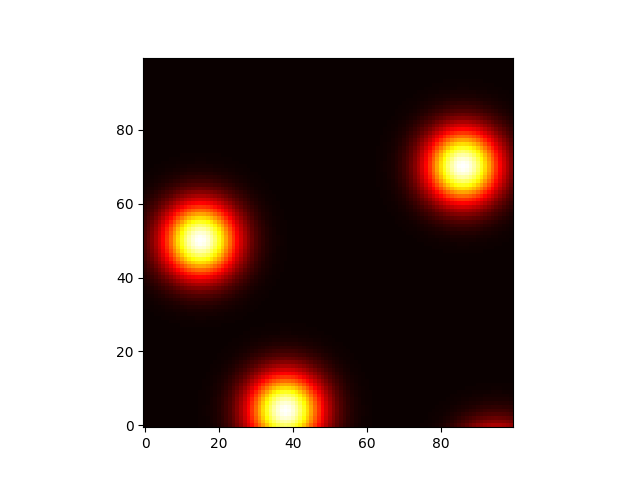

In [10]:
plt.close()
plt.imshow(heat_map.squeeze(), cmap='hot', interpolation='nearest', origin="lower")
plt.show()

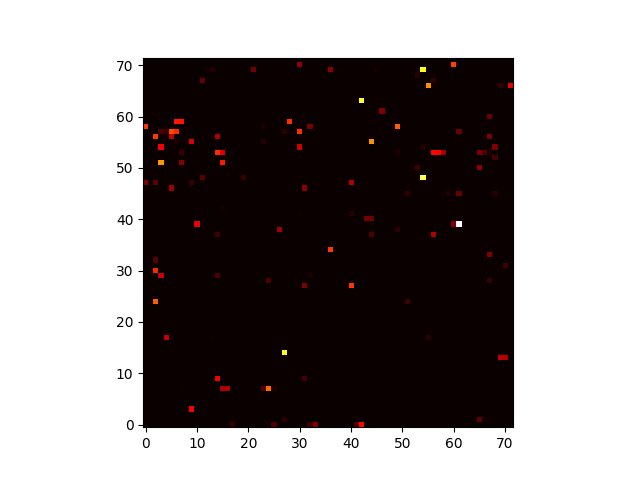

In [11]:
feat = feat.reshape(1, 72, 72).squeeze().cpu().numpy()
plt.close()
plt.imshow(feat, cmap='hot', interpolation='nearest', origin="lower")
plt.show()